

# Wine Quality

Using Keras functional API to train a model to predict two outputs. **[Wine Quality Dataset](https://archive.ics.uci.edu/ml/datasets/Wine+Quality)** from the **UCI machine learning repository**. It has separate datasets for red wine and white wine.

Normally, the wines are classified into one of the quality ratings specified in the attributes. We combine the two datasets to predict the wine quality and whether the wine is red or white solely from the attributes.

We model wine quality estimations as a regression problem and wine type detection as a binary classification problem.


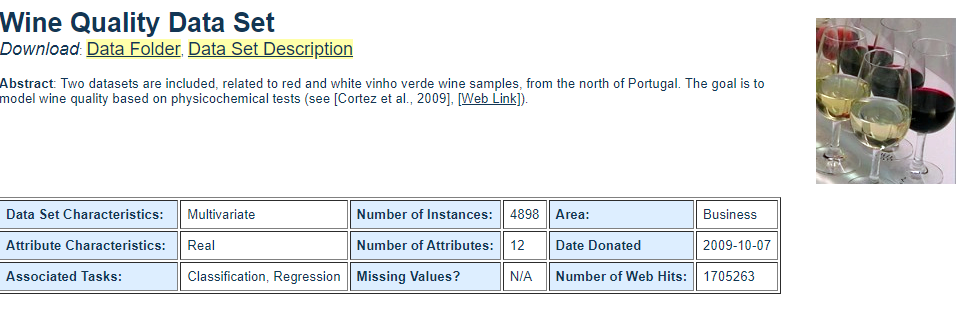

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import os

py_file_location = "/content/drive/My Drive/wine"
sys.path.append(os.path.abspath(py_file_location))


## Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import utils

## Load Dataset


Downloading the dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php).

### Pre-process the white wine dataset
We add a new column named `is_red` in the dataframe to indicate if the wine is white or red.
- In the white wine dataset, we fill the column `is_red` with  zeros (0).

In [ ]:

# URL of the white wine dataset
URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'

# load the dataset from the URL
white_df = pd.read_csv(URL, sep=";")

# fill the `is_red` column with zeros.
white_df["is_red"] = 0 # YOUR CODE HERE

# keep only the first of duplicate items
white_df = white_df.drop_duplicates(keep='first')


In [ ]:


utils.test_white_df(white_df)


 All public tests passed


In [ ]:
print(white_df.alcohol[0])
print(white_df.alcohol[100])

# EXPECTED OUTPUT
# 8.8
# 9.1

8.8
9.1


### Pre-process the red wine dataset
- In the red wine dataset, we fill in the column `is_red` with ones (1).

In [ ]:
# Please uncomment all lines in this cell and replace those marked with `# YOUR CODE HERE`.
# You can select all lines in this code cell with Ctrl+A (Windows/Linux) or Cmd+A (Mac), then press Ctrl+/ (Windows/Linux) or Cmd+/ (Mac) to uncomment.



# URL of the red wine dataset
URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'

# load the dataset from the URL
red_df = pd.read_csv(URL, sep=";")

# fill the `is_red` column with ones.
red_df["is_red"] = 1 # YOUR CODE HERE

# keep only the first of duplicate items
red_df = red_df.drop_duplicates(keep='first')


In [ ]:
utils.test_red_df(red_df)


 All public tests passed


In [ ]:
print(red_df.alcohol[0])
print(red_df.alcohol[100])

# EXPECTED OUTPUT
# 9.4
# 10.2

9.4
10.2


### Concatenate the datasets

Next, we concatenate the red and white wine dataframes.

In [ ]:
df = pd.concat([red_df, white_df], ignore_index=True)

In [ ]:
print(df.alcohol[0])
print(df.alcohol[100])

# EXPECTED OUTPUT
# 9.4
# 9.5

9.4
9.5


In [ ]:
# shuffle the data.
# YOU ARE NOT going to do that here because we want to test
# with deterministic data. But if you want the code to do it,
# it's in the commented line below:

#df = df.iloc[np.random.permutation(len(df))]

This will chart the quality of the wines.

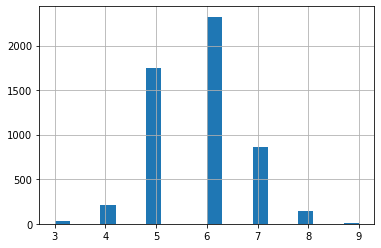

In [ ]:
df['quality'].hist(bins=20);

### Imbalanced data
We see from the plot above that the wine quality dataset is imbalanced.
- Since there are very few observations with quality equal to 3, 4, 8 and 9, we can drop these observations from your dataset.
- We can do this by removing data belonging to all classes except those > 4 and < 8.

In [ ]:
# Please uncomment all lines in this cell and replace those marked with `# YOUR CODE HERE`.
# You can select all lines in this code cell with Ctrl+A (Windows/Linux) or Cmd+A (Mac), then press Ctrl+/ (Windows/Linux) or Cmd+/ (Mac) to uncomment.



# get data with wine quality greater than 4 and less than 8
df = df[(df['quality'] > 4) & (df['quality'] < 8)]

# reset index and drop the old one
df = df.reset_index(drop=True)

In [ ]:
utils.test_df_drop(df)



 All public tests passed


In [ ]:
print(df.alcohol[0])
print(df.alcohol[100])

# EXPECTED OUTPUT
# 9.4
# 10.9

9.4
10.9


Plot again to see the new range of data and quality

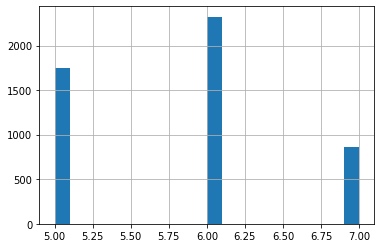

In [ ]:
df['quality'].hist(bins=20);

### Train Test Split

We split the datasets into training, test and validation datasets.
- The data frame should be split 80:20 into `train` and `test` sets.
- The resulting `train` should then be split 80:20 into `train` and `val` sets.
- The `train_test_split` parameter `test_size` takes a float value that ranges between 0. and 1, and represents the proportion of the dataset that is allocated to the test set.  The rest of the data is allocated to the training set.

In [ ]:

# split df into 80:20 train and test sets
train, test = train_test_split(df, test_size=0.2, random_state = 1)

# split train into 80:20 train and val sets
train, val = train_test_split(train, test_size=0.2, random_state = 1)

In [ ]:
utils.test_data_sizes(train.size, test.size, val.size)


 All public tests passed


We can explore the training stats. We can pop the labels 'is_red' and 'quality' from the data as these will be used as the labels


In [ ]:
train_stats = train.describe()
train_stats.pop('is_red')
train_stats.pop('quality')
train_stats = train_stats.transpose()

Explore the training stats!

In [ ]:
train_stats

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3155.0,7.221616,1.325297,3.80000,6.40000,7.00000,7.7000,15.60000
volatile acidity,3155.0,0.338929,0.162476,0.08000,0.23000,0.29000,0.4000,1.24000
citric acid,3155.0,0.321569,0.147970,0.00000,0.25000,0.31000,0.4000,1.66000
residual sugar,3155.0,5.155911,4.639632,0.60000,1.80000,2.80000,7.6500,65.80000
chlorides,3155.0,0.056976,0.036802,0.01200,0.03800,0.04700,0.0660,0.61100
free sulfur dioxide,3155.0,30.388590,17.236784,1.00000,17.00000,28.00000,41.0000,131.00000
total sulfur dioxide,3155.0,115.062282,56.706617,6.00000,75.00000,117.00000,156.0000,344.00000
density,3155.0,0.994633,0.003005,0.98711,0.99232,0.99481,0.9968,1.03898
pH,3155.0,3.223201,0.161272,2.72000,3.11000,3.21000,3.3300,4.01000
sulphates,3155.0,0.534051,0.149149,0.22000,0.43000,0.51000,0.6000,1.95000


In [ ]:
type(train_stats)

pandas.core.frame.DataFrame

In [ ]:
train_stats.to_pickle("train_stats")

In [ ]:
train_stats['mean']

fixed acidity             7.221616
volatile acidity          0.338929
citric acid               0.321569
residual sugar            5.155911
chlorides                 0.056976
free sulfur dioxide      30.388590
total sulfur dioxide    115.062282
density                   0.994633
pH                        3.223201
sulphates                 0.534051
alcohol                  10.504466
Name: mean, dtype: float64

In [ ]:
train_stats['std']

fixed acidity            1.325297
volatile acidity         0.162476
citric acid              0.147970
residual sugar           4.639632
chlorides                0.036802
free sulfur dioxide     17.236784
total sulfur dioxide    56.706617
density                  0.003005
pH                       0.161272
sulphates                0.149149
alcohol                  1.154654
Name: std, dtype: float64

### Get the labels

The features and labels are currently in the same dataframe.
- We want to store the label columns `is_red` and `quality` separately from the feature columns.  
- The following function, `format_output`, gets these two columns from the dataframe.
- `format_output` also formats the data into numpy arrays.
- We use the `format_output` and apply it to the `train`, `val` and `test` sets to get dataframes for the labels.

In [ ]:
def format_output(data):
    is_red = data.pop('is_red')
    is_red = np.array(is_red)
    quality = data.pop('quality')
    quality = np.array(quality)
    return (quality, is_red)

In [ ]:

# format the output of the train set
train_Y = format_output(train)

# format the output of the val set
val_Y = format_output(val)

# format the output of the test set
test_Y = format_output(test)

In [ ]:
utils.test_format_output(df, train_Y, val_Y, test_Y)

 All public tests passed


Notice that after you get the labels, the `train`, `val` and `test` dataframes no longer contain the label columns, and contain just the feature columns.
- This is because you used `.pop` in the `format_output` function.

In [ ]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
225,7.5,0.65,0.18,7.0,0.088,27.0,94.0,0.99915,3.38,0.77,9.4
3557,6.3,0.27,0.29,12.2,0.044,59.0,196.0,0.99782,3.14,0.40,8.8
3825,8.8,0.27,0.25,5.0,0.024,52.0,99.0,0.99250,2.87,0.49,11.4
1740,6.4,0.45,0.07,1.1,0.030,10.0,131.0,0.99050,2.97,0.28,10.8
1221,7.2,0.53,0.13,2.0,0.058,18.0,22.0,0.99573,3.21,0.68,9.9


### Normalize the data

We can normalize the data, x, using the formula:
$$x_{norm} = \frac{x - \mu}{\sigma}$$
- The `norm` function is defined below.
- We apply the `norm` function to normalize the dataframes that contains the feature columns of `train`, `val` and `test` sets.

In [ ]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [ ]:

# normalize the train set
norm_train_X = norm(train)

# normalize the val set
norm_val_X = norm(val)

# normalize the test set
norm_test_X = norm(test)
print(norm_train_X.shape)
print(norm_val_X.shape)

(3155, 11)
(789, 11)


In [ ]:
utils.test_norm(norm_train_X, norm_val_X, norm_test_X, train, val, test)


 All public tests passed


## Define the Model

Define the model using the functional API. The base model will be 2 `Dense` layers of 128 neurons each, and have the `'relu'` activation.
- Check out the documentation for [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

In [ ]:

def base_model(inputs):

    # connect a Dense layer with 128 neurons and a relu activation

    x = Dense(128, activation = 'relu')(inputs)

    # connect another Dense layer with 128 neurons and a relu activation
    x = Dense(128, activation = 'relu')(x)
    return x


In [ ]:
utils.test_base_model(base_model)

# Define output layers of the model

We add output layers to the base model.
- The model will need two outputs.

One output layer will predict wine quality, which is a numeric value.
- Define a `Dense` layer with 1 neuron.
- Since this is a regression output, the activation can be left as its default value `None`.

The other output layer will predict the wine type, which is either red `1` or not red `0` (white).
- Define a `Dense` layer with 1 neuron.
- Since there are two possible categories, you can use a sigmoid activation for binary classification.

Define the `Model`
- Define the `Model` object, and set the following parameters:
  - `inputs`: pass in the inputs to the model as a list.
  - `outputs`: pass in a list of the outputs that you just defined: wine quality, then wine type.
  - **Note**: please list the wine quality before wine type in the outputs, as this will affect the calculated loss if you choose the other order.

In [ ]:

def final_model(inputs):

    # get the base model
    x = base_model(inputs)

    # connect the output Dense layer for regression
    wine_quality = Dense(units='1', name='wine_quality')(x)

    # connect the output Dense layer for classification. this will use a sigmoid activation.
    wine_type = Dense(units='1', activation= 'sigmoid', name='wine_type')(x)

    # define the model using the input and output layers
    model = Model(inputs= inputs, outputs = [wine_quality, wine_type])

    return model

In [ ]:
utils.test_final_model(final_model)

## Compiling the Model

We compile the model. When setting the loss parameter of `model.compile`, we are setting the loss for each of the two outputs (wine quality and wine type).


In [ ]:

inputs = tf.keras.layers.Input(shape=(11,))
rms = tf.keras.optimizers.RMSprop(lr=0.0001)
model = final_model(inputs)

model.compile(optimizer=rms,
              loss = {'wine_type' : 'binary_crossentropy',
                      'wine_quality' : 'mse'
                     },
              metrics = {'wine_type' : 'accuracy',
                         'wine_quality': tf.keras.metrics.RootMeanSquaredError(),
                       }
             )


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
utils.test_model_compile(model)

## Training the Model

Fit the model to the training inputs and outputs.
- Check the documentation for [model.fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit).
- Remember to use the normalized training set as inputs.
- For the validation data, please use the normalized validation set.

In [ ]:
# Please uncomment all lines in this cell and replace those marked with `# YOUR CODE HERE`.
# You can select all lines in this code cell with Ctrl+A (Windows/Linux) or Cmd+A (Mac), then press Ctrl+/ (Windows/Linux) or Cmd+/ (Mac) to uncomment.



history = model.fit(norm_train_X, train_Y,
                    epochs = 180, validation_data=(norm_val_X, val_Y))

Epoch 1/180
99/99 [==============================] - 5s 11ms/step - loss: 22.9953 - wine_quality_loss: 22.3342 - wine_type_loss: 0.6611 - wine_quality_root_mean_squared_error: 4.7259 - wine_type_accuracy: 0.6101 - val_loss: 14.9204 - val_wine_quality_loss: 14.2986 - val_wine_type_loss: 0.6218 - val_wine_quality_root_mean_squared_error: 3.7814 - val_wine_type_accuracy: 0.7782
Epoch 2/180
99/99 [==============================] - 1s 8ms/step - loss: 9.4145 - wine_quality_loss: 8.8443 - wine_type_loss: 0.5702 - wine_quality_root_mean_squared_error: 2.9739 - wine_type_accuracy: 0.8532 - val_loss: 5.1110 - val_wine_quality_loss: 4.5958 - val_wine_type_loss: 0.5152 - val_wine_quality_root_mean_squared_error: 2.1438 - val_wine_type_accuracy: 0.8733
Epoch 3/180
99/99 [==============================] - 1s 8ms/step - loss: 3.7389 - wine_quality_loss: 3.2848 - wine_type_loss: 0.4541 - wine_quality_root_mean_squared_error: 1.8124 - wine_type_accuracy: 0.8748 - val_loss: 2.9681 - val_wine_quality_lo

In [ ]:
model.save('/content/drive/MyDrive/wine1/model/model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/wine1/model/model/assets


In [ ]:
reloaded = keras.models.load_model('/content/drive/MyDrive/wine1/model/model')

In [ ]:
utils.test_history(history)

In [ ]:
# Gather the training metrics
loss, wine_quality_loss, wine_type_loss, wine_quality_rmse, wine_type_accuracy = model.evaluate(x=norm_val_X, y=val_Y)

print()
print(f'loss: {loss}')
print(f'wine_quality_loss: {wine_quality_loss}')
print(f'wine_type_loss: {wine_type_loss}')
print(f'wine_quality_rmse: {wine_quality_rmse}')
print(f'wine_type_accuracy: {wine_type_accuracy}')

# EXPECTED VALUES
# ~ 0.30 - 0.38
# ~ 0.30 - 0.38
# ~ 0.018 - 0.030
# ~ 0.50 - 0.62
# ~ 0.97 - 1.0

# Example:
#0.3657050132751465
#0.3463745415210724
#0.019330406561493874
#0.5885359048843384
#0.9974651336669922

25/25 [==============================] - 0s 4ms/step - loss: 0.3362 - wine_quality_loss: 0.3094 - wine_type_loss: 0.0268 - wine_quality_root_mean_squared_error: 0.5563 - wine_type_accuracy: 0.9937

loss: 0.3362477123737335
wine_quality_loss: 0.3094320297241211
wine_type_loss: 0.026815738528966904
wine_quality_rmse: 0.5562661290168762
wine_type_accuracy: 0.9936628937721252


## Analyze the Model Performance

Note that the model has two outputs. The output at index 0 is quality and index 1 is wine type

So, round the quality predictions to the nearest integer.

In [ ]:
predictions = reloaded.predict(norm_test_X)
quality_pred = predictions[0]
type_pred = predictions[1]

In [ ]:
type(norm_test_X)

pandas.core.frame.DataFrame

In [ ]:
norm_test_X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
2372,-0.242675,-0.670428,-0.551254,1.949312,-0.108035,-0.660714,-0.371425,1.187100,-0.329886,-0.228299,-0.783322
1900,-0.469039,-0.793523,-0.078184,1.345815,-0.488447,0.905703,0.880633,1.103907,1.158285,-0.630581,-0.610110
275,1.266420,0.560521,0.867954,-0.701761,-0.135207,-1.414915,-1.746926,0.055672,0.786243,1.112638,1.728253
3276,-0.619949,2.099207,-0.416091,-0.378459,0.326722,-0.312622,0.545575,-0.386917,-0.267879,-0.898768,-1.043140
2360,-0.469039,-0.670428,-0.416091,-0.831081,-0.325413,-0.834761,0.228152,-0.410211,0.848250,0.442169,-0.436898
...,...,...,...,...,...,...,...,...,...,...,...
4464,-0.091765,-0.670428,-0.280928,-0.701761,-0.298241,0.151502,-0.212714,-1.551623,-0.639921,-1.502190,1.295223
518,2.398242,-0.362691,1.476186,-0.529333,1.304925,-1.472931,-1.694022,1.386764,0.166171,0.643310,-0.869928
3016,-0.921768,-0.485786,-0.956741,0.397464,-0.053690,1.137765,1.392037,0.425050,-0.081857,-0.697627,-1.302958
4671,-0.921768,-0.424239,-0.416091,-0.831081,-0.515619,0.093487,0.404498,-1.125673,1.468321,-0.697627,0.515768


In [ ]:
norm_test_X.iloc[0]

fixed acidity          -0.242675
volatile acidity       -0.670428
citric acid            -0.551254
residual sugar          1.949312
chlorides              -0.108035
free sulfur dioxide    -0.660714
total sulfur dioxide   -0.371425
density                 1.187100
pH                     -0.329886
sulphates              -0.228299
alcohol                -0.783322
Name: 2372, dtype: float64

In [ ]:
print(quality_pred[0])

# EXPECTED OUTPUT
# 5.6 - 6.0

[5.590748]


In [ ]:
print(type_pred[0])
print(type_pred[944])

# EXPECTED OUTPUT
# A number close to zero
# A number close to or equal to 1

[0.00020536]
[0.99999547]


### Plot Utilities

We define a few utilities to visualize the model performance.

In [ ]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


In [ ]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

In [ ]:
def plot_diff(y_true, y_pred, title = '' ):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.plot([-100, 100], [-100, 100])
    return plt

### Plots for Metrics

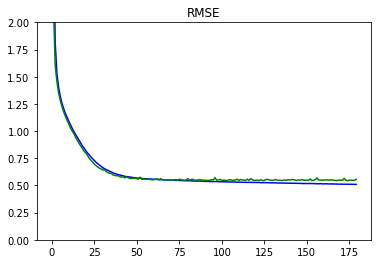

In [ ]:
plot_metrics('wine_quality_root_mean_squared_error', 'RMSE', ylim=2)

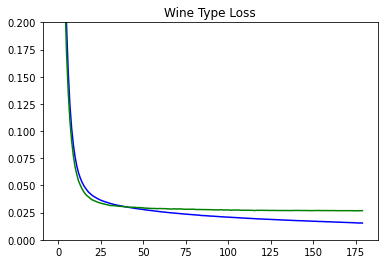

In [ ]:
plot_metrics('wine_type_loss', 'Wine Type Loss', ylim=0.2)

### Plots for Confusion Matrix

Plot the confusion matrices for wine type. The model performs well for prediction of wine type from the confusion matrix and the loss metrics.

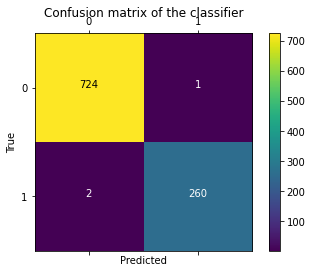

In [ ]:
plot_confusion_matrix(test_Y[1], np.round(type_pred), title='Wine Type', labels = [0, 1])

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns


target_names=['white','red']

print(metrics.classification_report(test_Y[1], np.round(type_pred),target_names=target_names))
print("Classification accuracy: %0.6f" % metrics.accuracy_score(test_Y[1],np.round(type_pred)))

              precision    recall  f1-score   support

       white       1.00      1.00      1.00       725
         red       1.00      0.99      0.99       262

    accuracy                           1.00       987
   macro avg       1.00      1.00      1.00       987
weighted avg       1.00      1.00      1.00       987

Classification accuracy: 0.996960


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test_Y[1], np.round(type_pred))


0.9954935509344565

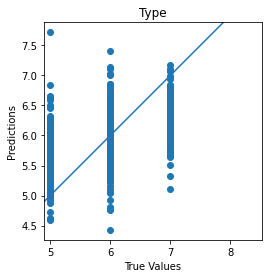

In [ ]:
scatter_plot = plot_diff(test_Y[0], quality_pred, title='Type')

# Prediction on new data

In [ ]:
! pip install gtts

In [ ]:
from gtts import gTTS
from IPython.display import Audio

In [ ]:
fixed_acidity= 	7.4
volatile_acidity=0.7
citric_acid=0
residual_sugar=1.9
chlorides=0.076
free_sulfur_dioxide= 11
total_sulfur_dioxide=	34
density=	0.9978
pH=	3.51
sulphates=0.56
alcohol=9.4

In [ ]:
test1 =np.array([ fixed_acidity,	volatile_acidity,	citric_acid,	residual_sugar,	chlorides, free_sulfur_dioxide, total_sulfur_dioxide,	density, pH,	sulphates, alcohol])


In [ ]:
print(test1)

[ 7.4     0.7     0.      1.9     0.076  11.     34.      0.9978  3.51
  0.56    9.4   ]


In [ ]:
train_stats= pd.read_pickle("/content/train_stats")

In [ ]:
train_stats

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3155.0,7.221616,1.325297,3.80000,6.40000,7.00000,7.7000,15.60000
volatile acidity,3155.0,0.338929,0.162476,0.08000,0.23000,0.29000,0.4000,1.24000
citric acid,3155.0,0.321569,0.147970,0.00000,0.25000,0.31000,0.4000,1.66000
residual sugar,3155.0,5.155911,4.639632,0.60000,1.80000,2.80000,7.6500,65.80000
chlorides,3155.0,0.056976,0.036802,0.01200,0.03800,0.04700,0.0660,0.61100
free sulfur dioxide,3155.0,30.388590,17.236784,1.00000,17.00000,28.00000,41.0000,131.00000
total sulfur dioxide,3155.0,115.062282,56.706617,6.00000,75.00000,117.00000,156.0000,344.00000
density,3155.0,0.994633,0.003005,0.98711,0.99232,0.99481,0.9968,1.03898
pH,3155.0,3.223201,0.161272,2.72000,3.11000,3.21000,3.3300,4.01000
sulphates,3155.0,0.534051,0.149149,0.22000,0.43000,0.51000,0.6000,1.95000


In [ ]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [ ]:
test1=norm(test1)
test2=pd.DataFrame(test1).to_numpy()
test2=test2.reshape(1, -1)

In [ ]:
test2

array([[ 0.13459888,  2.222302  , -2.17320483, -0.70176065,  0.51692836,
        -1.124838  , -1.42950304,  1.0539912 ,  1.77835676,  0.17398185,
        -0.956534  ]])

In [ ]:
predictions = reloaded.predict(test2)
quality_pred = predictions[0]
type_pred = predictions[1]

In [ ]:
print(quality_pred[0])

[5.1560526]


In [ ]:
tts1 = gTTS("According to our model the predicted quality is: " + str(quality_pred[0]))
tts1.save('1.wav')
sound_file = '1.wav'
Audio(sound_file, autoplay=True)

In [ ]:
print(type_pred[0])

[0.9999994]


In [ ]:
if type_pred[0]<0.5:
  type1="white";
  print("white")

else:
  type1="red"
  print("red")

tts1 = gTTS("According to our model the type is: " + type1)
tts1.save('1.wav')
sound_file = '1.wav'
Audio(sound_file, autoplay=True)

red


In [ ]:
test_Y[1]